#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/Documents/kaggle_siim_covid/src


## Imports

In [3]:
import os
import cv2
import glob
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
from matplotlib.patches import Rectangle

In [4]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model
from model_zoo.encoders import get_encoder

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

In [5]:
from params import *
from data.extraction import *
from utils.boxes import Boxes, expand_boxes

# PP

In [6]:
import ast

from map_boxes import mean_average_precision_for_boxes

In [7]:
df = prepare_dataframe().copy()

In [8]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [9]:
df = add_additional_boxes(df)

In [10]:
boxes = pd.read_csv('../output/lungs_train')
df = df.merge(boxes, left_on="image_id", right_on="img_name", suffixes=('', '_lung'))

In [11]:
df['boxes_lung'] = df['boxes_lung'].apply(lambda x: np.array(ast.literal_eval(x)))
df['confidences'] = df['confidences'].apply(lambda x: np.array(ast.literal_eval(x)))

In [12]:
pred_oof = np.load("/home/theo/Documents/kaggle_siim_covid/logs/2021-07-30/0/pred_oof_img.npy")

In [13]:
from sklearn.metrics import *
roc_auc_score(df['img_target'], pred_oof)

0.9018662130719447

In [48]:
PLOT = True
COMPUTE_MAP = False
COMPUTE_CROPS = True

[[ 545  594 1491 1989]
 [2017  581 1494 1831]]
[[248, 380, 3807, 2783]]


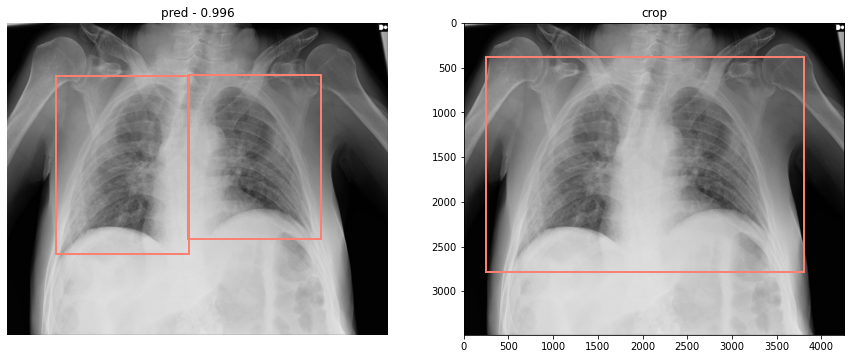

[[1588   11 1218 1852]
 [ 267   18 1229 1757]]
[[120, 0, 2832, 2048]]


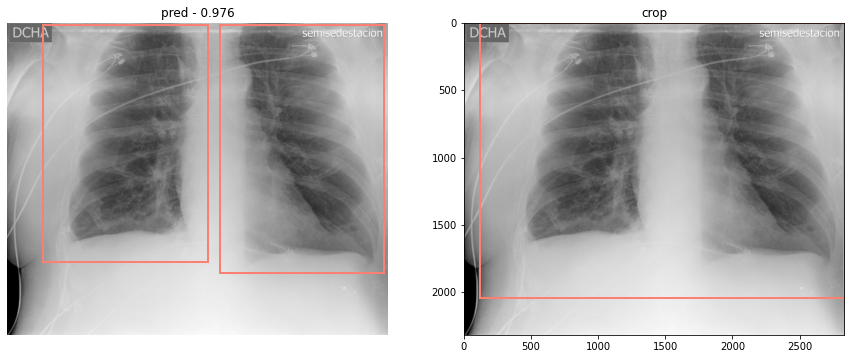

[[ 535   73 1073 1386]
 [1566  186 1059 1587]]
[[326, 0, 2834, 1943]]


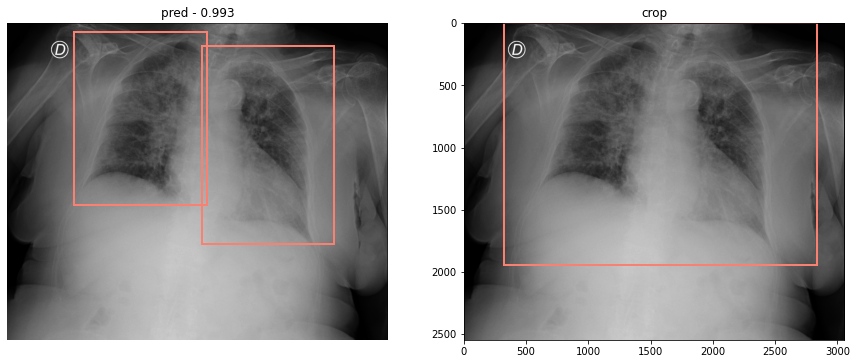

[[ 741  333 1422 2385]
 [2134  280 1665 2768]]
[[435, 3, 4104, 3324]]


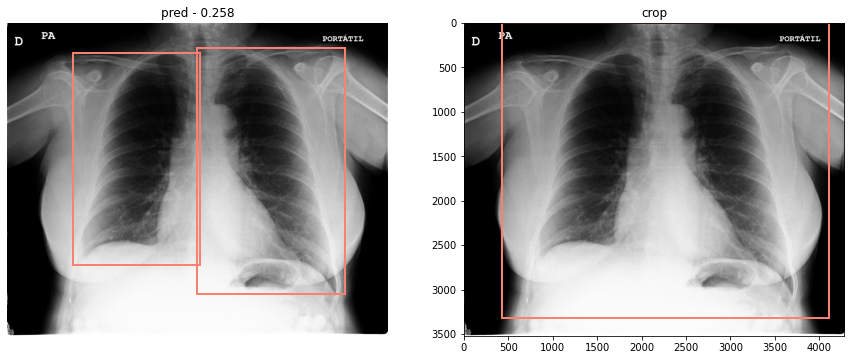

[[ 548  293 1367 1928]
 [1950  179 1372 2085]]
[[270, 0, 3408, 2472]]


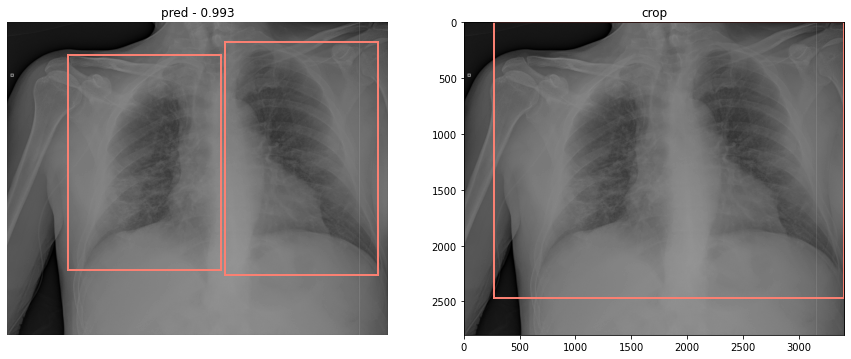

[[ 327  151 1258 2069]
 [1593  148 1121 1942]]
[[88, 0, 2952, 2427]]


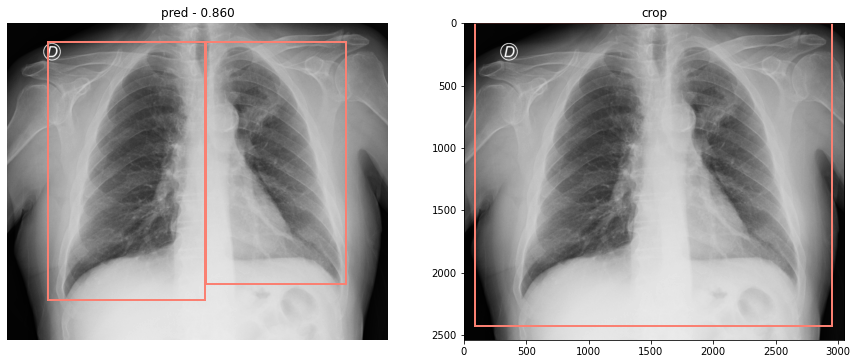

[[ 456   58 1163 1823]
 [1605   97 1031 1731]]
[[238, 0, 2846, 2063]]


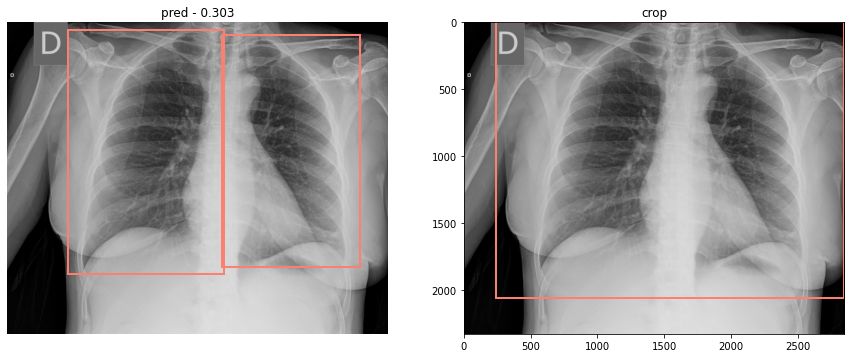

[[ 173  493 1255 1827]
 [1506  432 1349 1914]]
[[78, 240, 2872, 2416]]


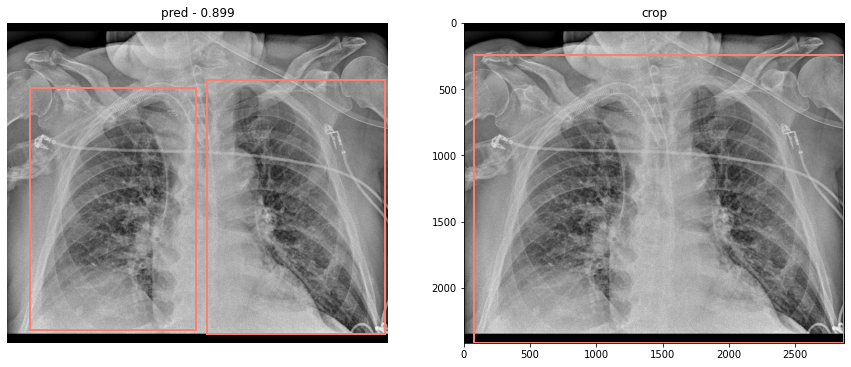

[[1434  199 1156 1464]
 [ 365  121 1086 1358]]
[[142, 0, 2812, 1817]]


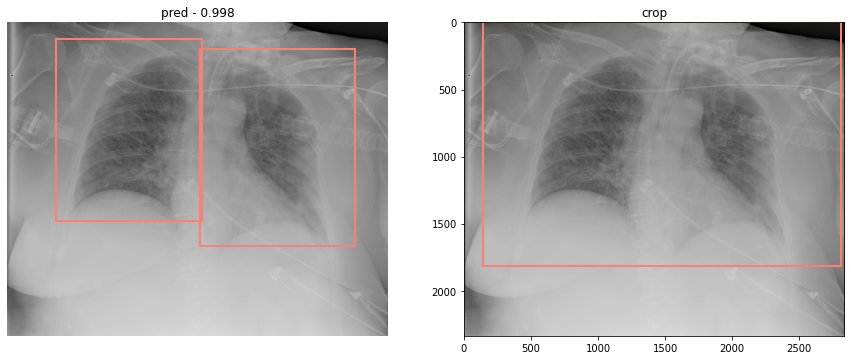

[[ 455   79  984 1485]
 [1497    7 1138 1826]]
[[236, 0, 2836, 2015]]


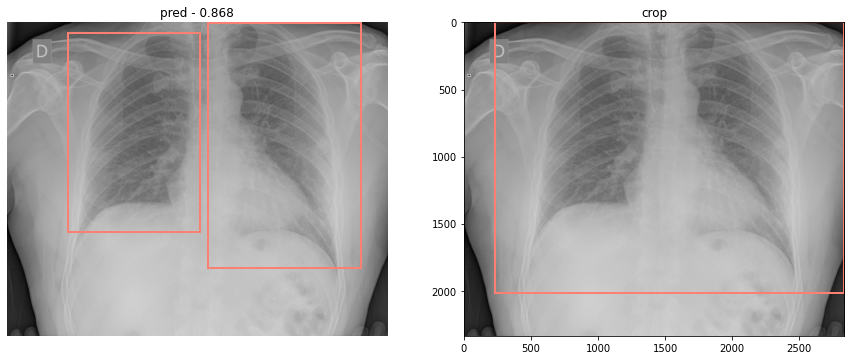

[[ 385  423 1576 2257]
 [2097  362 1584 2437]]
[[55, 118, 4010, 3042]]


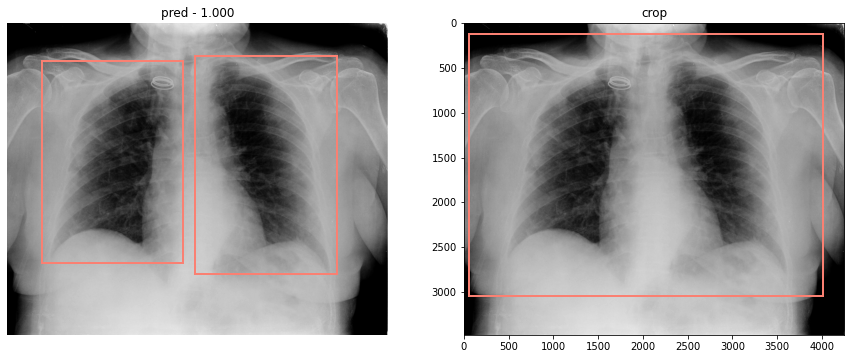

[[ 573  714  888 1692]
 [1528  693  979 1712]]
[[379, 521, 2700, 2577]]


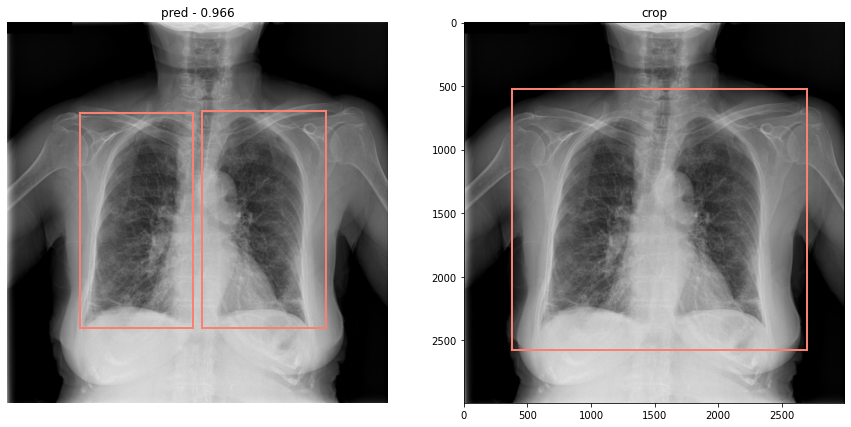

In [54]:
boxes_pred, boxes_truth = [], []
tps, fns, fps = 0, 0, 0
boxes_dic_for_crop = {}

for i in range(len(df)):
    pred = np.array(df['boxes_lung'][i])
    truth = np.array(df['boxes'][i])
    starts = np.array(df['crop_starts'][i])

    shape_crop = df['shape_crop'][i]
    shape = df['shape'][i]
    
    truth = Boxes(truth, shape, bbox_format="coco")["albu"]
    
    pred = Boxes(pred, shape_crop, bbox_format="albu")["coco"]
    
    if len(pred):
        pred[:, 0] += starts[1]
        pred[:, 1] += starts[0]

    if COMPUTE_CROPS:
        pred_ = Boxes(pred.copy(), shape, bbox_format="coco")["pascal_voc"]
        
        x_start = pred_[:, 0].min()
        y_start = pred_[:, 1].min()
        x_end = pred_[:, 2].max()
        y_end = pred_[:, 3].max()

        pred_for_crop = Boxes(np.array([[x_start, y_start, x_end, y_end]]), shape, bbox_format="pascal_voc")
        pred_for_crop.expand(1.2)
        boxes_dic[df["image_id"][i]] = pred_for_crop["pascal_voc"].tolist()

    pred = Boxes(pred, shape, bbox_format="coco")
    pred = expand_boxes(pred, 1)["albu"]
    
    confidence = pred_oof[i]
#     confidence = df['img_target'][i]
    
    bp = []
    for b in pred:
        bp.append([
            df["image_id"][i], "opacity", confidence, b[0], b[2], b[1], b[3]
        ])
    boxes_pred += bp

    bt = []
    for b in truth:
        bt.append([
            df["image_id"][i], "opacity", b[0], b[2], b[1], b[3]
        ])

    boxes_truth += bt

    if COMPUTE_MAP:
        if len(bt):
            ap = mean_average_precision_for_boxes(bt, bp, verbose=0)[0]
        else:
            ap = 0
        print(f' -> mAP : {ap:.3f}')

        if confidence > 0.5:
            if ap == 1:
                tps += 2
            elif 0 < ap < 1:  # 1 correct, rest wrong
                tps += 1
                fns += len(bt) - 1
                fps += 1
            else:  # 2 wrong
                fps += 2
                fns += len(bt)
        else:
            fns += len(bt)

    if PLOT:  # or 0 < ap < 1:
        if np.max(starts) >= -1: # 100:
            xray_path = DATA_PATH + "train/" + df["study_id"][i] + "/" + df['series_id'][i] + "/" + df["image_id"][i] + ".dcm"
            image, _ = read_xray(xray_path)

            plt.figure(figsize=(15, 7))
            plt.subplot(1, 2, 1)
            plot_sample(image, pred, bbox_format="albu")
            plt.title(f'pred - {confidence :.3f}')
#             plt.subplot(1, 2, 2)
#             plot_sample(image, truth, bbox_format="albu")
#             plt.title('truth')
            
            plt.subplot(1, 2, 2)
            print(boxes_dic[df["image_id"][i]])
            plot_sample(image, np.array(boxes_dic[df["image_id"][i]]), bbox_format="pascal_voc")
            plt.title('crop')
            plt.axis(True)

            plt.show()

        if i > 10:
            break

In [ ]:
mean_average_precision_for_boxes(boxes_truth, boxes_pred)

In [ ]:
json.dump(boxes_dic